In [31]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Load Data

In [32]:
# center,left,right,steering,throttle,brake,speed
import os
import csv

samples = []
with open('../data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        samples.append(line)


from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

from scipy import misc
import cv2
import numpy as np
import sklearn

def generator(samples, batch_size=256):
    
    correction = 0.2
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset + batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_angle = float(batch_sample[3])
                left_angle = center_angle + correction
                right_angle = center_angle - correction
                # Add all three image and its corresponding steer angles into the training set.
                for file_name, steer in zip(batch_sample[:3], [center_angle, left_angle, right_angle]):
                    file_path = '../data/' + file_name.strip()
                    images.append(misc.imread(file_path)) # read image as RGB format
                    angles.append(steer)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

In [33]:
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

In [34]:
print("Training set size:", len(train_samples))
print("Validation set size", len(validation_samples))

Training set size: 10691
Validation set size 2673


# Preprocess Data

# Train Model

In [35]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D
from keras.layers import Cropping2D
from keras.models import Model
import matplotlib.pyplot as plt

model = Sequential()
model.add(Cropping2D(cropping=((70,25), (0,0)), input_shape=(160,320,3))) # crop top 10 pixels and bottom 25
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(65, 320, 3))) # normalize images
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation="relu"))
# model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation="relu"))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation="relu"))
# model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Convolution2D(64, 3, 3, activation="relu"))
model.add(Flatten())
model.add(Dense(100))
# model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history = model.fit_generator(
    train_generator, 
    samples_per_epoch=len(train_samples), 
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples), 
    nb_epoch=20)

model.save('model.h5')

Epoch 1/20
10656/10691 [============================>.] - ETA: 0s - loss: 0.1610

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


10752/10691 [==============================] - 25s - loss: 0.1600 - val_loss: 0.0704
Epoch 2/20
10752/10691 [==============================] - 25s - loss: 0.0734 - val_loss: 0.0827
Epoch 3/20
10761/10691 [==============================] - 25s - loss: 0.0656 - val_loss: 0.0877
Epoch 4/20
10752/10691 [==============================] - 25s - loss: 0.0674 - val_loss: 0.0641
Epoch 5/20
10752/10691 [==============================] - 25s - loss: 0.0593 - val_loss: 0.0671
Epoch 6/20
10761/10691 [==============================] - 25s - loss: 0.0571 - val_loss: 0.0710
Epoch 7/20
10752/10691 [==============================] - 25s - loss: 0.0606 - val_loss: 0.0582
Epoch 8/20
10752/10691 [==============================] - 25s - loss: 0.0556 - val_loss: 0.0627
Epoch 9/20
10761/10691 [==============================] - 25s - loss: 0.0530 - val_loss: 0.0795
Epoch 10/20
10752/10691 [==============================] - 25s - loss: 0.0579 - val_loss: 0.0560
Epoch 11/20
10752/10691 [=========================

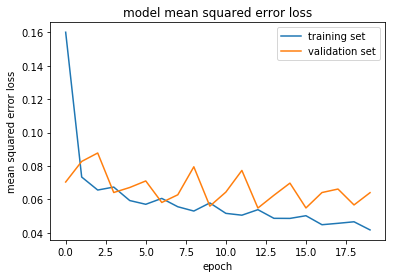

In [36]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()